In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import functools
import pandas as pd

%matplotlib inline

# Multilayer Neural Network

Antrenarea unei retele neurale multi-strat presupune rabdare si un orizont larg de cunostinte. Este mai degraba "black magic" decat programare. Codul vostru poate fi perfect, insa reteaua nu invata nici de frica. Asa incat ati fost avertizati!

Antrenarea cere o combinatie de pricepere, setare de parametri si initializare de ponderi. In cele ce urmeaza am sa incerc sa va ghidez in asa fel incat sa ajungeti la rezultatul final, si anume la o acuratete de test de peste 95%. 

Va rog neaparat sa cititi cartea lui Michael Nielsen, http://neuralnetworksanddeeplearning.com, pentru ca doar prin programare si suportul de curs nu veti reusi sa ajustati parametrii retelei. Trebuie sa intelegeti cum functioneaza reteaua pentru ca sa o puteti antrena cu succes.

Un blog interesant este si https://mmlind.github.io/Simple_3-Layer_Neural_Network_for_MNIST_Handwriting_Recognition/; l-am folosit pentru setarea parametrilor, insa performantele obtinute sunt mai bune decat scrie acolo.

Revin inca o data: ca sa antrenati reteaua cu succes trebuie sa:
 * scrieti codul fara erori;
 * initializati ponderile intr-un anumit fel;
 * folositi anumiti parametri de antrenare.
 
Altfel RETEAUA NU INVATA.

In [2]:
def load_dataset(file_name):
    """
    Returns a list of dictionaries, each element of the list is an instance
    """
    # ...
    return pd.read_csv(file_name, header=None).values

In [3]:
def form_x_and_y(dataset):
    """
    Forms the dataframe as numpy arrays from the given list of dictionaries
    """
    # ...
    return dataset[:, 1:], dataset[:, 0][:, np.newaxis]

In [4]:
def normalize(x):
    """
    Normalization means division by 255 -> values in [0, 1]
    """
    return x / 255.0

In [5]:
def show_sample(data, label):
    """
    Shows an instance as a 2D image
    """
    # Make those columns into a array of 8-bits pixels
    # The pixel intensity values are integers from 0 to 255
    pixels = np.array(data, dtype='uint8')

    # Reshape the array into 28 x 28 array (2-dimensional array)
    n = int(np.sqrt(len(pixels)))
    assert n**2 == len(pixels)
    pixels = pixels.reshape(n, n)

    # Plot
    plt.title('Label is {label}'.format(label=label))
    plt.imshow(pixels, cmap='gray')
    plt.show()

In [6]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))
    #return np.tanh(z)

# este posibil sa testam ca atat functia sigmoida cat si functia tanh() sunt calculate corect
# folositi testul pentru ca altfel erorile sunt greu, daca nu imposibil de gasit!
assert(sigmoid(0) == 0.5)


def sigmoid_derivative(z):
    rez = sigmoid(z)
    return rez * (1 - rez)
    
    
def tanh_derivative(z):
    return 1.0 - (np.tanh(z) ** 2)

assert(sigmoid_derivative(0) == 0.25)
# idem, faceti teste pentru tanh(). Valoarea tanh(0) trebuie sa fie 0.
assert(np.tanh(0) == 0)
# si pt tanh' ?

def softmax(z):
    # z e de forma (nL, nrIntrari)
    # ...
    rez = np.exp(z) 
    return rez / np.sum(rez, axis=0)[np.newaxis, :] # suma pe coloane o facem vector linie

# cred ca trebuie softmax_derivative...

# definiti testele pentru softmax si folositi-le
assert(np.all(softmax( np.array([[5], [5]]) ) == np.array([[0.5], [0.5]])))
assert(np.all(softmax( np.array([[0], [0]]) ) == np.array([[0.5], [0.5]])))
assert(np.sum(softmax(np.array([[4], [2]]))) == 1.0)


def one_hot(p, k):
    """ One-hot encoding converteste o eticheta, de exemplu 7, in [0 0 0 0 0 0 0 1 0 0]
        parametrul p este pozitia pe care se pune "1"
        parametrul k este numarul total de clase (elemente in lista)
        Am facut conventia ca one_hot sa intoarca o lista
    """
    onehot = [0] * k
    onehot[p] = 1
    return onehot
    
assert(one_hot(0, 2) == [1, 0])
assert(one_hot(2, 4) == [0, 0, 1, 0])

In [7]:
def assert_func(weights, biases, sizes):
    """ Functia are rolul de a verifica corectitudinea arhitecturii retelei
    """
    assert(len(biases) == len(weights))
    assert(len(biases) == len(sizes) - 1)
    assert(len(weights) == len(sizes) - 1)
    for i in range(len(biases)):
        assert(biases[i].shape[0] == sizes[i + 1])
        assert(biases[i].shape[1] == 1)
        assert(weights[i].shape[0] == sizes[i + 1])
        assert(weights[i].shape[1] == sizes[i])

# XOR Problem

In [8]:
# la inceput, am folosit problema XOR ca sa antrenez o retea cu 3 straturi,
# cu neuroni cu functie de activare sigmoida (inclusiv pe ultimul strat)
# structura aleasa a fost cu functie de cost patratica (nu cross-entropy)
# si cu neuroni cu functie de activare sigmoida
# 
# rata de invatare a fost 4.0 si a trebuit sa fac in jur de 4000 de epoci, cu antrenare 
# de tip stochastic gradient descent (update dupa fiecare pattern), pana sa clasifice 
# cu acuratete de 100%
#
# in acest caz, setul de test este totuna cu setul de antrenare 
x_train = np.array([
    [0.3, 0.3],
    [0.7, 0.7],
    [0.3, 0.7],
    [0.7, 0.3]
])
y_train = np.array([
    [0],
    [0],
    [1],
    [1]
])
y_train = np.array([one_hot(int(x), 2) for x in y_train])
#print(y_train)

In [21]:
# sizes este o lista care pastreaza numarul de neuroni de pe fiecare strat, pornind de la intrare
sizes = [2, 3, 2] # pentru XOR 
#sizes = [28 * 28, 100, 10]
layers = len(sizes)


weights = [0] * (layers - 1)
biases = [0] * (layers - 1)

# strategia aleasa a fost de a construi intai reteaua cu functii de activare sigmoida pentru XOR
# pentru acest tip de retea, ponderile au fost initializate aleator (uniform) cu valori cuprinse intre -1 si 1

for i in range(len(weights)):
    # weights[i] = np.random.random(tuple(sizes[i + 1 - len(sizes) : (i-1) - len(sizes) :-1])) * 2 - 1
    weights[i] = np.random.random((sizes[i + 1], sizes[i])) * 2 - 1
    biases[i] = np.random.random((sizes[i+1], 1)) * 2 - 1 # biasurile sunt vector coloana
    
    
# for every layer, the bias vector has the same dimension as the number of neurons
# ...

# modul de lucru: scrieti o functie si verificati apoi ca functioneaza pe un pattern (pentru asta aveti XOR, ca sa puteti
# urmari totul pas cu pas).
# ATENTIE: nu scrieti tot codul deodatat fara sa verificati nimic decat la sfarsit; sigur nu va merge si eroarea va fi greu de gasit.

# verificati corectitudinea arhitecturii construite
assert_func(weights, biases, sizes)

In [10]:
# def feedforward(x, weights, biases):
#     """ Propagarea inainte folosind neuroni cu functie de activare sigmoida peste tot """
#     z = [0] * (len(weights) + 1)
#     a = [0] * (len(weights) + 1)
#     a[0] = x.copy().T
    
#     for i in range(1, len(z)):
#         z[i] = weights[i-1] @ a[i-1] + biases[i-1]
#         a[i] = sigmoid(z[i])
    
#     return z, a

def feedforward(x, weights, biases):
    """ Propagarea inainte folosind neuroni cu functie de activare sigmoida peste tot """
    z = 0
    a = 0
    if len(x.shape) == 1:
        a = x[:, np.newaxis]
    else:
        a = x.copy().T
    
    for i in range(len(weights)):
        z = weights[i] @ a + biases[i]
        a = sigmoid(z)
    
    return a

assert(feedforward(x_train[0], weights, biases).shape[0] == sizes[-1]) # pentru o singura intrare
assert(feedforward(x_train, weights, biases).shape == (sizes[-1], x_train.shape[0])) # pentru toate intrarile simultan
# feedforward(x_train, weights, biases).shape

In [15]:
def error(x_set, y_set, weights, biases):
    """ Calculeaza iesirea sub forma de one-hot encoding folosind feedforward(),
        si o foloseste pentru a numara cate pattern-uri sunt antrenate corect
    """
    # y_set e de forma (p, k)
    a = feedforward(x_set, weights, biases).T
    
    pred = np.zeros(a.shape, dtype=int)
    pred[np.arange(pred.shape[0]), np.argmax(a, axis=1)] = 1
    #print(pred)
    return np.count_nonzero(np.equal(pred, y_set).all(axis=1))

#error(x_train, y_train, weights, biases)

In [12]:
def forwardpass(x, weights, biases):
    """ Propagarea inainte folosind neuroni cu functie de activare sigmoida peste tot """
    z = [0] * (len(weights) + 1)
    a = [0] * (len(weights) + 1)
    a[0] = x[:, np.newaxis]
    
    for i in range(1, len(z)):
        z[i] = weights[i-1] @ a[i-1] + biases[i-1]
        a[i] = sigmoid(z[i])
    
    return z, a

def backprop(x, y, weights, biases, layers):
    # for the forward pass, we would compute activations and nets (the z-s)
    # for every layer, since we would use it in the backward pass (delta calculation)
    z, a = forwardpass(x, weights, biases)

    # for the cross-entropy function, be sure to change the activation
    # and delta calculatios for the last layer
    
    # forward pass computes activations
    # see a above

    # declare deltas for the backward pass
    delta_w = [0] * len(weights)
    delta_b = [0] * len(biases)
    
    # first do the computations for the last layer
    # one-hot-uit sau nu?
    # cu minus sau nu?
    delta = (y[:, np.newaxis] - a[-1]) * sigmoid_derivative(z[-1])
    
    delta_w[-1] = delta @ a[-2].T
    delta_b[-1] = delta
    
    # start with the layer before last
    
    for i in range(len(weights) - 2, -1, -1):
        delta = weights[i+1].T @ delta * sigmoid_derivative(z[i+1])
                                                        
        delta_w[i] = delta @ a[i].T
        delta_b[i] = delta
    
    return delta_w, delta_b

# test1, test2 = backprop(x_train[0], y_train[0], weights, biases, layers)
# print(test1)
# print(test2)

In [13]:
def compute_batch(batch_x, batch_y, weights, biases, eta, lmbda, layers):    
    """ Recomputes the weights and biases using only a batch """
    """ make use of the assert_func to verify the dimensionalities """
    delta_w = [0] * (layers - 1)
    delta_b = [0] * (layers - 1)
    for i in range(len(weights)):
        delta_w[i] = np.zeros((sizes[i + 1], sizes[i]))
        delta_b[i] = np.zeros((sizes[i+1], 1)) 
    assert_func(delta_w, delta_b, sizes)
    
    for i in range(batch_x.shape[0]):
        x = batch_x[i]
        y = batch_y[i]
        dw, db = backprop(x, y, weights, biases, layers)
        assert_func(dw, db, sizes)
        for j in range(len(dw)):
            delta_w[j] += dw[j]
            delta_b[j] += db[j]
        assert_func(delta_w, delta_b, sizes)
        
    # here we have the update of the weights, computed using the learning rate eta,
    # and the regularization factor lambda
    # for starters, you can put lambda to 0 (for XOR problem, just to see it is working)
    # anyway, you should choose a small lambda (< 0.01 or even smaller)
    for i in range(len(weights)):
        weights[i] -= eta * (delta_w[i] / batch_x.shape[0] + lmbda * weights[i])
        biases[i] -= eta * (delta_b[i] / batch_x.shape[0])
    
    # before returning, call the assert function
    # after you are convinced the code is correct, comment out the asserts,
    # because these incur great performance penalties
    assert_func(weights, biases, sizes)
    return weights, biases


#compute_batch(x_train[:2], y_train[:2], weights, biases, 4.0, 0.01, layers)

In [26]:
# for the MNIST, batch size is 10; for XOR, it is 1

# For the XOR problem, be warned that the correct classification may be attained even only after more than 4000 epochs
# eta = 4.0, epochs = 2000

eta = 5
epochs = 5000
lmbda = 0
batch_size = 1

for epoch in range(epochs):
    perm = [i for i in range(x_train.shape[0])]
    np.random.shuffle(perm)
    
    # generate batches
    x_batches = x_train[perm]
    y_batches = y_train[perm]
    
    nb_batches = int(x_batches.shape[0] / batch_size)
   
    # run batches and change weights
    for i in range(nb_batches):
        batch_x = x_batches[i * batch_size: i * batch_size + batch_size]
        batch_y = y_batches[i * batch_size: i * batch_size + batch_size]
        weights, biases = compute_batch(batch_x, batch_y, weights, biases, eta, lmbda, layers)
    
    # print( error(x_test, y_test, weights, biases) )
    print( error(x_train, y_train, weights, biases) )


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


# MNIST Problem

In [8]:
# first, load the datasets
train_set = load_dataset('mnist_train.csv')
test_set = load_dataset('mnist_test.csv')

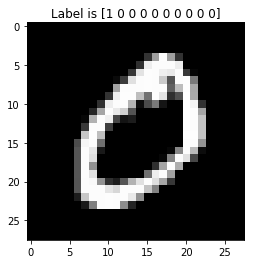

In [9]:
# definiti numarul de clase
k = 10

x_train, y_train = form_x_and_y(train_set)
assert np.shape(x_train) == (len(train_set), 28*28)
assert np.shape(y_train) == (len(train_set), 1)

y_train = np.array([one_hot(int(y), k) for y in y_train])
assert np.shape(y_train) == (len(train_set), k)

x_test, y_test = form_x_and_y(test_set)
assert np.shape(x_test) == (len(test_set), 28*28)
assert np.shape(y_test) == (len(test_set), 1)

y_test = np.array([one_hot(int(y), k) for y in y_test])
assert np.shape(y_test) == (len(test_set), k)

# inspectati vizual un sample, sa fie ce va asteptati
show_sample(x_train[1], y_train[1])

x_train = normalize(x_train)
x_test = normalize(x_test)

In [10]:
sizes = [28 * 28, 100, 10]
layers = len(sizes)


weights = [0] * (layers - 1)
biases = [0] * (layers - 1)

# ulterior, functiile de activare au fost schimbate la tanh() cu exceptia celor de pe ultimul strat unde 
# s-a folosit softmax(), iar functia de cost a fost schimbata din patratul diferentei la cross-entropy

# pentru aceasta strunctura, initializarea corecta in asa fel incat neuronii sa nu se satureze, este CRUCIALA
# a se vedea http://neuralnetworksanddeeplearning.com/chap3.html#weight_initialization
# daca nu initializati ponderile cum trebuie, puteti sa va confruntati cu situatia ca reteaua NU INVATA DELOC

for i in range(len(weights)):
    # weights[i] = np.random.random(tuple(sizes[i + 1 - len(sizes) : (i-1) - len(sizes) :-1])) * 2 - 1
    weights[i] = np.random.normal(0, 1.0 / np.sqrt(sizes[i]), (sizes[i + 1], sizes[i]))
    biases[i] = np.random.normal(0, 1.0 / np.sqrt(sizes[i]), (sizes[i + 1], 1)) # biasurile sunt vector coloana


# deci puteti folosi initializarea asa cum este descrisa de Glorot in http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf?hc_location=ufi
# (aveti link si la curs, [26] Xavier Glorot, Yoshua Bengio, "Understanding the difficulty of training
# deep feedforward neural networks"). Puteti sa le initializati si cu valori mai mici decat este descris acolo, asta pare sa ajute.

# for every layer, the bias vector has the same dimension as the number of neurons
# ...

# modul de lucru: scrieti o functie si verificati apoi ca functioneaza pe un pattern (pentru asta aveti XOR, ca sa puteti
# urmari totul pas cu pas).
# ATENTIE: nu scrieti tot codul deodatat fara sa verificati nimic decat la sfarsit; sigur nu va merge si eroarea va fi greu de gasit.

# verificati corectitudinea arhitecturii construite
assert_func(weights, biases, sizes)

# print(weights)

In [11]:
def feedforward2(x, weights, biases):
    """ Propagarea inainte folosind neuroni cu functie de activare softmax pe ultimul strat """
    z = 0
    if len(x.shape) == 1:
        a = x[:, np.newaxis]
    else:
        a = x.copy().T
    
    for i in range(len(weights) - 1):
        z = weights[i] @ a + biases[i]
        a = np.tanh(z)
    
    return softmax(weights[-1] @ a + biases[-1])

assert(feedforward2(x_train[0], weights, biases).shape[0] == sizes[-1])
assert(feedforward2(x_train, weights, biases).shape == (sizes[-1], x_train.shape[0]))
feedforward2(x_train, weights, biases).shape

(10, 60000)

In [12]:
def error2(x_set, y_set, weights, biases):
    """ Calculeaza iesirea sub forma de one-hot encoding folosind feedforward2()
        si o foloseste pentru a numara cate pattern-uri sunt antrenate corect
    """
        # y_set e de forma (p, k)
    a = feedforward2(x_set, weights, biases).T
    
    pred = np.zeros(a.shape, dtype=int)
    pred[np.arange(pred.shape[0]), np.argmax(a, axis=1)] = 1
    
    return np.count_nonzero(np.equal(pred, y_set).all(axis=1))

error2(x_train, y_train, weights, biases)

6792

In [13]:
def forwardpass2(x, weights, biases):
    """ Propagarea inainte folosind neuroni cu functie de activare tanh si softmax """
    z = [0] * (len(weights) + 1)
    a = [0] * (len(weights) + 1)
    a[0] = x[:, np.newaxis]
    
    for i in range(1, len(z)-1):
        z[i] = weights[i-1] @ a[i-1] + biases[i-1]
        a[i] = np.tanh(z[i])
    
    z[-1] = weights[-1] @ a[-2] + biases[-1]
    a[-1] = softmax(z[-1])
    
    return z, a

# test1, test2 = forwardpass2(x_train[0], weights, biases)
# print(test1[1].shape)
# print(test1[2].shape)
# print(test2[1].shape)
# print(test2[2].shape)

def backprop2(x, y, weights, biases, layers):
    # for the forward pass, we would compute activations and nets (the z-s)
    # for every layer, since we would use it in the backward pass (delta calculation)
    z, a = forwardpass2(x, weights, biases)

    # for the cross-entropy function, be sure to change the activation
    # and delta calculatios for the last layer
    
    # forward pass computes activations
    # see a above

    # declare deltas for the backward pass
    delta_w = [0] * len(weights)
    delta_b = [0] * len(biases)
    
    # first do the computations for the last layer
    # one-hot-uit sau nu?
    # cu minus sau nu?
    delta = a[-1] - y[:, np.newaxis]
    
    delta_w[-1] = delta @ a[-2].T
    delta_b[-1] = delta
    
    # start with the layer before last
    
    for i in range(len(weights) - 2, -1, -1):
        delta = weights[i+1].T @ delta * sigmoid_derivative(z[i+1])
                                                        
        delta_w[i] = delta @ a[i].T
        delta_b[i] = delta
    
    return delta_w, delta_b

# test1, test2 = backprop(x_train[0], y_train[0], weights, biases, layers)
# print(test1[0].shape)
# print(test1[1].shape)
# print(test2[0].shape)
# print(test2[1].shape)

In [14]:
def compute_batch2(batch_x, batch_y, weights, biases, eta, lmbda, layers):    
    """ Recomputes the weights and biases using only a batch """
    """ make use of the assert_func to verify the dimensionalities """
    delta_w = [0] * (layers - 1)
    delta_b = [0] * (layers - 1)
    for i in range(len(weights)):
        delta_w[i] = np.zeros((sizes[i + 1], sizes[i]))
        delta_b[i] = np.zeros((sizes[i+1], 1)) 
    assert_func(delta_w, delta_b, sizes)
    
    for i in range(batch_x.shape[0]):
        x = batch_x[i]
        y = batch_y[i]
        dw, db = backprop2(x, y, weights, biases, layers)
        assert_func(dw, db, sizes)
        for j in range(len(dw)):
            delta_w[j] += dw[j]
            delta_b[j] += db[j]
        assert_func(delta_w, delta_b, sizes)
        
    # here we have the update of the weights, computed using the learning rate eta,
    # and the regularization factor lambda
    # for starters, you can put lambda to 0 (for XOR problem, just to see it is working)
    # anyway, you should choose a small lambda (< 0.01 or even smaller)
    for i in range(len(weights)):
        weights[i] -= eta * (delta_w[i] / batch_x.shape[0] + lmbda * weights[i])
        biases[i] -= eta * (delta_b[i] / batch_x.shape[0])
    
    # before returning, call the assert function
    # after you are convinced the code is correct, comment out the asserts,
    # because these incur great performance penalties
    assert_func(weights, biases, sizes)
    return weights, biases


#compute_batch(x_train[:2], y_train[:2], weights, biases, 4.0, 0.01, layers)

In [59]:
# for the MNIST, batch size is 10; for XOR, it is 1

# For the XOR problem, be warned that the correct classification may be attained even only after more than 4000 epochs
# eta = 4.0, epochs = 2000

eta = 0.1
epochs =5
lmbda = 0.001
batch_size = 10

for epoch in range(epochs):
    perm = [i for i in range(x_train.shape[0])]
    np.random.shuffle(perm)
    
    # generate batches
    x_batches = x_train[perm]
    y_batches = y_train[perm]
    
    nb_batches = int(x_batches.shape[0] / batch_size)
   
    # run batches and change weights
    for i in range(nb_batches):
        batch_x = x_batches[i * batch_size: i * batch_size + batch_size]
        batch_y = y_batches[i * batch_size: i * batch_size + batch_size]
        weights, biases = compute_batch2(batch_x, batch_y, weights, biases, eta, lmbda, layers)
    
    print( error2(x_test, y_test, weights, biases) )


9592
9594
9598
9602
9617


Accuracy is 96.17%


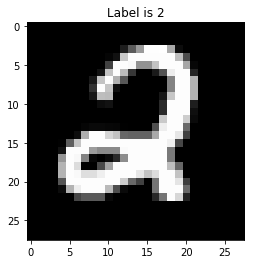

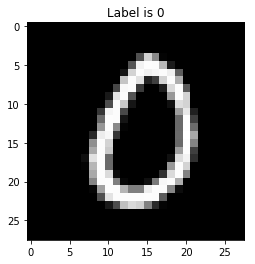

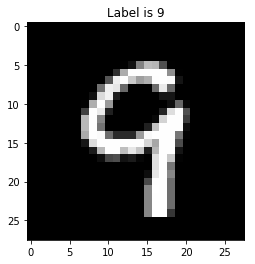

In [61]:
print("Accuracy is %3.2f%%" % (error2(x_test, y_test, weights, biases) / 100))
y = feedforward2(x_test[147], weights, biases)
show_sample(x_test[147]*255, np.argmax(y))
y = feedforward2(x_test[148], weights, biases)
show_sample(x_test[148]*255, np.argmax(y))
y = feedforward2(x_test[150], weights, biases)
show_sample(x_test[150]*255, np.argmax(y))
#for i in range(200, 250):
    #show_sample(x_test[i]*255, np.argmax(y))